In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from models import *
import gc
import random
import numpy as np
import matplotlib.pyplot as plt

def Volatile(x):
    return Variable(x, volatile=True)

Trining model on electrode number 73


/Users/berryweinstein/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py:325: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self.forward(*input, **kwargs)


[ 1] 0.0444919490
valid loss: 0.0482711482
[ 2] 0.0355796088
valid loss: 0.0472738457
[ 3] 0.0349501739
valid loss: 0.0471559630
[ 4] 0.0346155846
valid loss: 0.0472624348
[ 5] 0.0343407123
valid loss: 0.0472118567
[ 6] 0.0342893929
valid loss: 0.0473691798
[ 7] 0.0339593462
valid loss: 0.0475602016
[ 8] 0.0337283934
valid loss: 0.0476300884
[ 9] 0.0335154960
valid loss: 0.0478696090
Shuffling and re trainning on electrode 73
[ 1] 0.0494211449
valid loss: 0.0322761600
[ 2] 0.0366141820
valid loss: 0.0322555505
[ 3] 0.0361942472
valid loss: 0.0324683517
[ 4] 0.0359213508
valid loss: 0.0326148508
[ 5] 0.0357107098
valid loss: 0.0328388485
[ 6] 0.0356010417
valid loss: 0.0330212148
[ 7] 0.0354113112
valid loss: 0.0331080429
Done electrode 73, Pearson statistics (1st - real, 2nd- shuffled)
[(0.24655980928763363, 3.2817794048838769e-12), (-0.054698394150097925, 0.12790775316514863)]


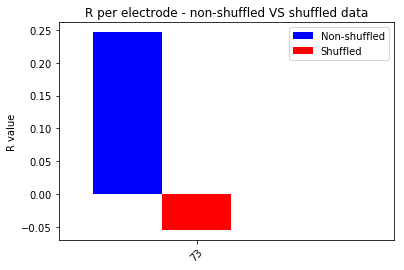

In [2]:
stat_dict = {}
batch_size = 8
# electrodes = [1, 2, 3, 27, 28 ,29 ,30, 31, 32, 33, 34, 44, 45, 46, 47, 49, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 103, 104, 114]
# electrodes = [66, 67, 68, 69, 70, 71, 72, 10, 11, 12, 50, 51, 52, 60]
electrodes = [73]

for e in electrodes:
    print ("Trining model on electrode number %d" % (e))
    stat_dict[e] = []

    total_minibatches = Data.create_minibatches('resnet_v1_50', 'block3', batch_size, e)

    X_train, X_test, y_train, y_test = train_test_split([i[0] for i in total_minibatches], [i[1] for i in total_minibatches], test_size=0.2)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)



    # net = Fetures2ECoGTrans(features_dim=X_test[0].shape[3], hidden_dim=y_test[0].shape[1])
    net = Fetures2ECoGTrans(features_dim=X_test[0].shape, hidden_dim=int(X_test[0].shape[3]/8))
    opt = torch.optim.RMSprop(net.parameters(), lr=1e-3)
    mse = torch.nn.MSELoss()

    n_train = len(y_train)
    epoch = 0
    hit_loss_grow = 0
    max_epochs = 50
    min_loss = np.inf
    n_valid = len(y_valid)
    while epoch < max_epochs:
        sum_loss = 0
        for idx, t in enumerate(X_train):
            net.zero_grad()
            w, output = net(Variable(t))
            loss = mse(output, Variable(y_train[idx]))
            loss.backward()
            opt.step()
            sum_loss += loss.data[0]
        epoch += 1
        print('[{:2d}] {:5.10f}'.format(epoch, sum_loss / n_train))
        sum_loss = 0
        for idx, t in enumerate(X_valid):
            w, output = net(Volatile(t))
            loss = mse(output, Volatile(y_valid[idx]))
            sum_loss += loss.data[0]

        valid_loss = sum_loss / n_valid
        print('valid loss: {:5.10f}'.format(valid_loss))
        if (min_loss < valid_loss):
            if (hit_loss_grow > 3):
                break
            hit_loss_grow += 1
        min_loss = valid_loss




    n_valid = len(y_test)
    sum_loss = 0
    # per_elec_target = np.empty((0, y_test[0].shape[1]))
    # per_elec_output = np.empty((0, y_test[0].shape[1]))
    per_elec_target = []
    per_elec_output = []
    for s in y_test:
        per_elec_target.extend(list(s))
        # per_elec_target = np.append(per_elec_target, np.array(s), axis=0)

    for idx, t in enumerate(X_test):
        w, output = net(Volatile(t))
        per_elec_output.extend(list(output.data))
        loss = mse(output, Volatile(y_test[idx]))
        sum_loss += loss.data[0]


    stat_dict[e].append(stats.pearsonr(per_elec_target, per_elec_output))
    gc.collect()


    ## SHUFFLE and rerun ###
    print ("Shuffling and re trainning on electrode %d" %(e))
    X = [i[0] for i in total_minibatches]
    random.shuffle(total_minibatches)
    Y_shuff = [i[1] for i in total_minibatches]
    X_train, X_test, y_train, y_test = train_test_split(X, Y_shuff, test_size=0.2)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

    # net = Fetures2ECoGTrans(features_dim=X_test[0].shape[3], hidden_dim=y_test[0].shape[1])
    net = Fetures2ECoGTrans(features_dim=X_test[0].shape, hidden_dim=int(X_test[0].shape[3] / 8))
    opt = torch.optim.RMSprop(net.parameters(), lr=1e-3)
    mse = torch.nn.MSELoss()

    n_train = len(y_train)
    epoch = 0
    hit_loss_grow = 0
    max_epochs = 50
    min_loss = np.inf
    n_valid = len(y_valid)
    while epoch < max_epochs:
        sum_loss = 0
        for idx, t in enumerate(X_train):
            net.zero_grad()
            w, output = net(Variable(t))
            loss = mse(output, Variable(y_train[idx]))
            loss.backward()
            opt.step()
            sum_loss += loss.data[0]
        epoch += 1
        print('[{:2d}] {:5.10f}'.format(epoch, sum_loss / n_train))
        sum_loss = 0
        for idx, t in enumerate(X_valid):
            w, output = net(Volatile(t))
            loss = mse(output, Volatile(y_valid[idx]))
            sum_loss += loss.data[0]

        valid_loss = sum_loss / n_valid
        print('valid loss: {:5.10f}'.format(valid_loss))
        if (min_loss < valid_loss):
            if (hit_loss_grow > 3):
                break
            hit_loss_grow += 1
        min_loss = valid_loss

    n_valid = len(y_test)
    sum_loss = 0
    # per_elec_target = np.empty((0, y_test[0].shape[1]))
    # per_elec_output = np.empty((0, y_test[0].shape[1]))
    per_elec_target = []
    per_elec_output = []
    for s in y_test:
        per_elec_target.extend(list(s))
        # per_elec_target = np.append(per_elec_target, np.array(s), axis=0)

    for idx, t in enumerate(X_test):
        w, output = net(Volatile(t))
        per_elec_output.extend(list(output.data))
        loss = mse(output, Volatile(y_test[idx]))
        sum_loss += loss.data[0]

    stat_dict[e].append(stats.pearsonr(per_elec_target, per_elec_output))
    gc.collect()

    print("Done electrode %d, Pearson statistics (1st - real, 2nd- shuffled)" % (e))
    print(stat_dict[e])




fig = plt.figure()
ax = fig.add_subplot(111)

N = len(electrodes)
real_stat = [v[0][0] for k, v in stat_dict.items()]
shuff_stat = [v[1][0] for k, v in stat_dict.items()]

ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
real_bar = ax.bar(ind, real_stat, width,
                color='blue')

shuff_bar = ax.bar(ind+width, shuff_stat, width,
                color='red')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
# ax.set_ylim(0,45)
ax.set_ylabel('R value')
ax.set_title('R per electrode - non-shuffled VS shuffled data')

xTickMarks = [k for k in stat_dict.keys()]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (real_bar[0], shuff_bar[0]), ('Non-shuffled', 'Shuffled') )

plt.show()